## 1. Raster analysis
1. Write a function that plots the projected total and urban population from 2010
to 2100 for a selected country as a line chart. The attached countries.tif
contains the country ID for each cell; this list shows which ID is which country.

2. Generate a global raster that shows only the cells that are projected to lose
population, and indicates how much the population in those cells is projected to
decline between 2010 and 2100.

In [577]:
import rasterio
import pandas as pd
import bokeh
import urllib.request
import zipfile
import os
import matplotlib as mlp
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline

In [476]:
countries =rasterio.open('countries.tif')
{i: dtype for i, dtype in zip(countries.indexes, countries.dtypes)}


{1: 'float64'}

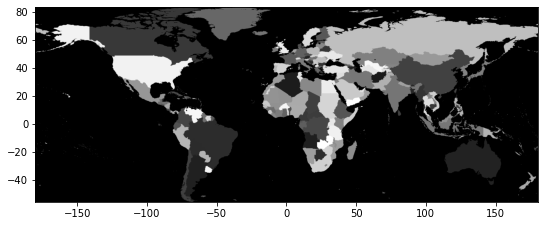

In [477]:
left, bottom, right, top = countries.bounds
f, ax = plt.subplots(1, figsize=(9, 9))
# Add raster layer
ax.imshow(countries.read(1), cmap='gray', extent=(left, right, bottom, top))

In [478]:
rural_inequality_tif=[]
total_inequality_tif=[]
for year in range(2010,2101,10):
    file_name='popdynamics-1-8th-pop-base-year-projection-ssp-2000-2100-rev01-proj-ssp4-geotiff/SSP4/Rural/GeoTIFF/ssp4rur'+str(year)+'.tif'
    rural_inequality_tif.append( rasterio.open(file_name))

for year in range(2010,2101,10):
    file_name='popdynamics-1-8th-pop-base-year-projection-ssp-2000-2100-rev01-proj-ssp4-geotiff/SSP4/Total/GeoTIFF/ssp4_'+str(year)+'.tif'
    total_inequality_tif.append( rasterio.open(file_name))


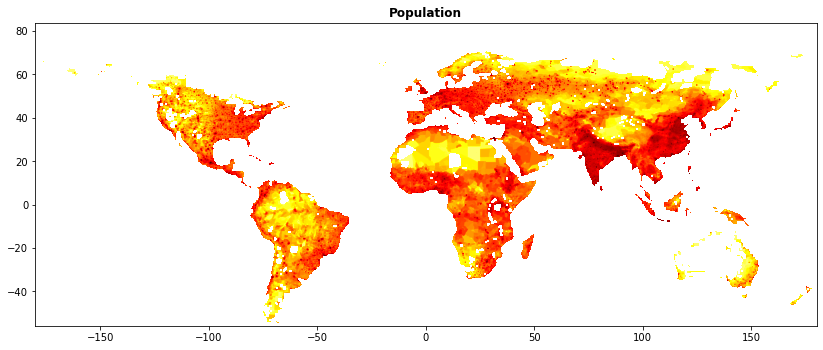

In [625]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(14, 14))
show((total_inequality_tif[0]), title='Population', norm=LogNorm(), cmap='hot_r')

In [626]:
india = countries.read(1) == 356
india

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [627]:
total_inequality_tif[0].read(1)*india

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

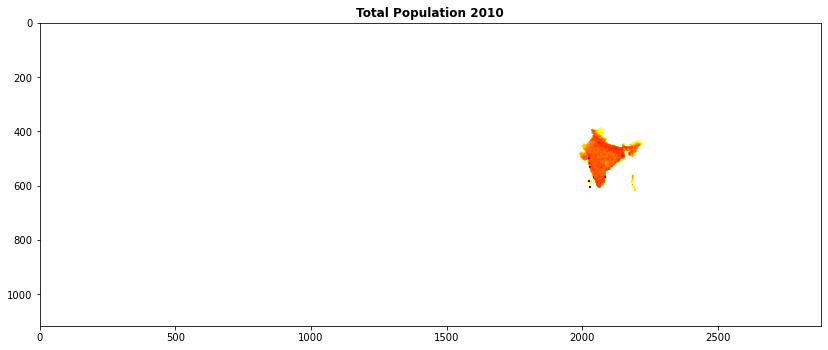

In [628]:
plt.figure(figsize=(14, 14))
show((total_inequality_tif[0].read(1)*india), title='Total Population 2010', norm=LogNorm(), cmap='hot_r')

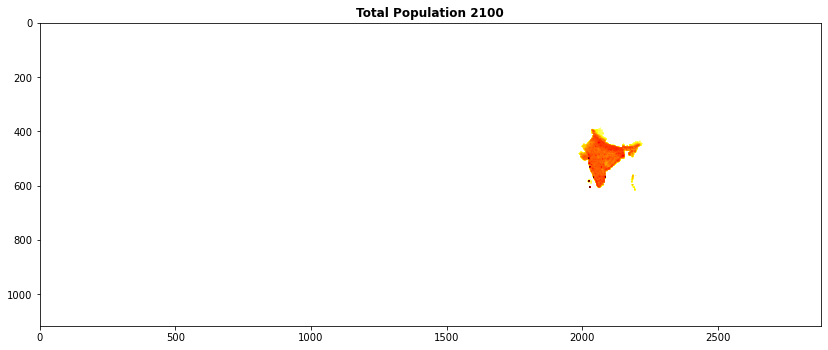

In [629]:
plt.figure(figsize=(14, 14))
show((total_inequality_tif[9].read(1)*india), title='Total Population 2100', norm=LogNorm(), cmap='hot_r')

In [630]:
rp = rural_inequality_tif[0].read(1)[india]
np.sum(rp)


-1293699403

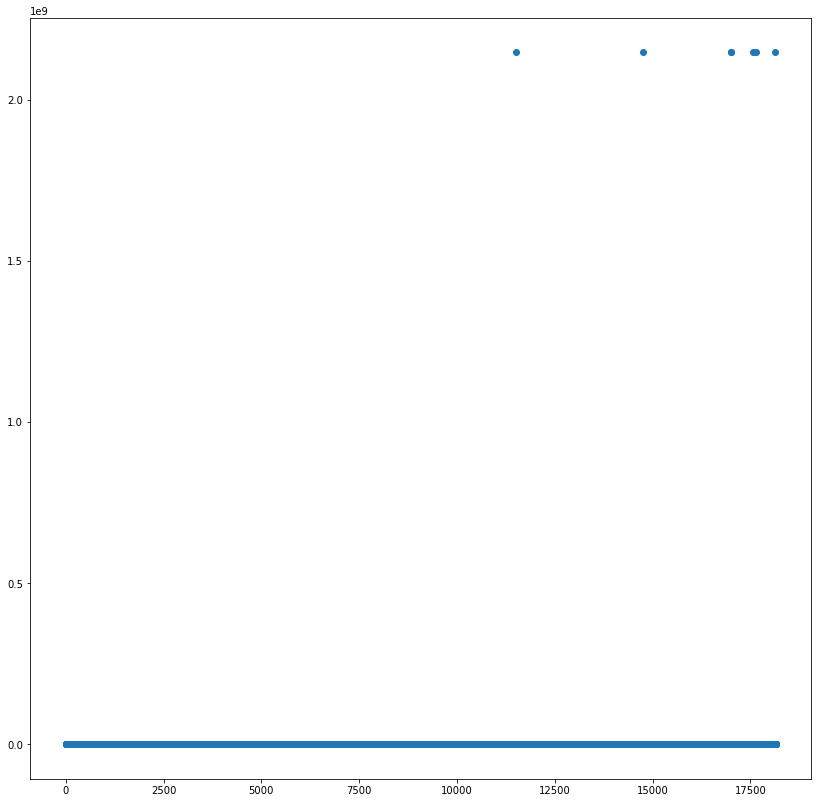

In [631]:
plt.figure(figsize=(14, 14))
plt.scatter(range(0,len(rp)),rp)
plt.show()

In [632]:
rp[rp>5000000]=0

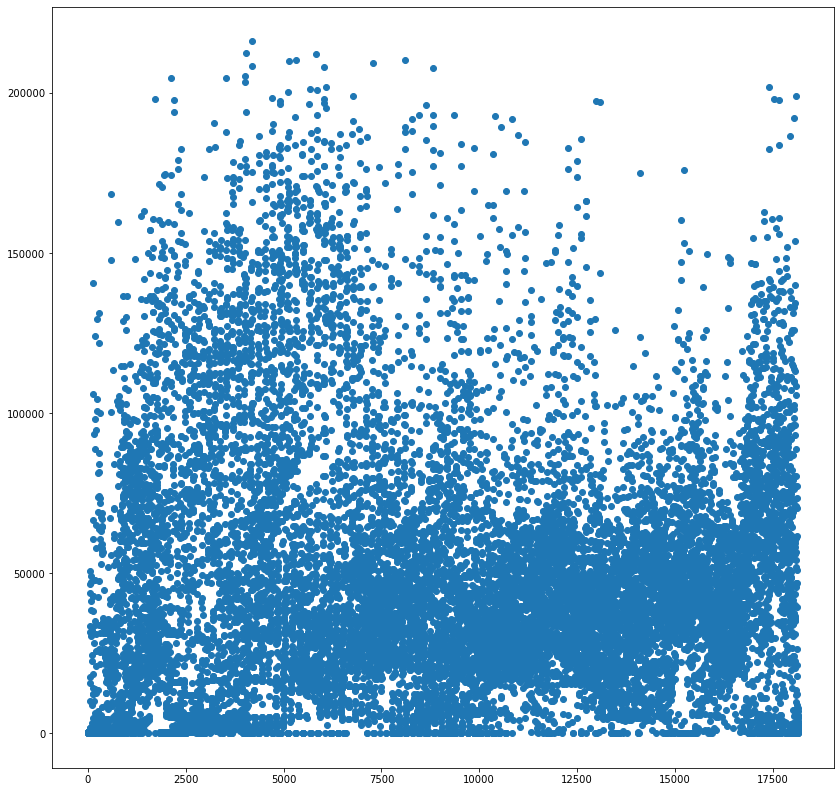

In [633]:
plt.figure(figsize=(14, 14))
plt.scatter(range(0,len(rp)),rp)
plt.show()

In [634]:
rural_pop_india = []
total_pop_india = []

for i in range(0,10):
    rp = rural_inequality_tif[i].read(1)[india]
    rp = rp[rp<5000000]
    rural_pop_india.append(np.sum(rp))
    
    tp = total_inequality_tif[i].read(1)[india]
    tp = tp[tp<5000000]
    total_pop_india.append(np.sum(tp))

In [635]:
total_pop_india

[1217396265,
 1368552999,
 1480992665,
 1546430981,
 1570615148,
 1550365605,
 1483038041,
 1383917544,
 1267336757,
 1151011890]

<function matplotlib.pyplot.show(*args, **kw)>

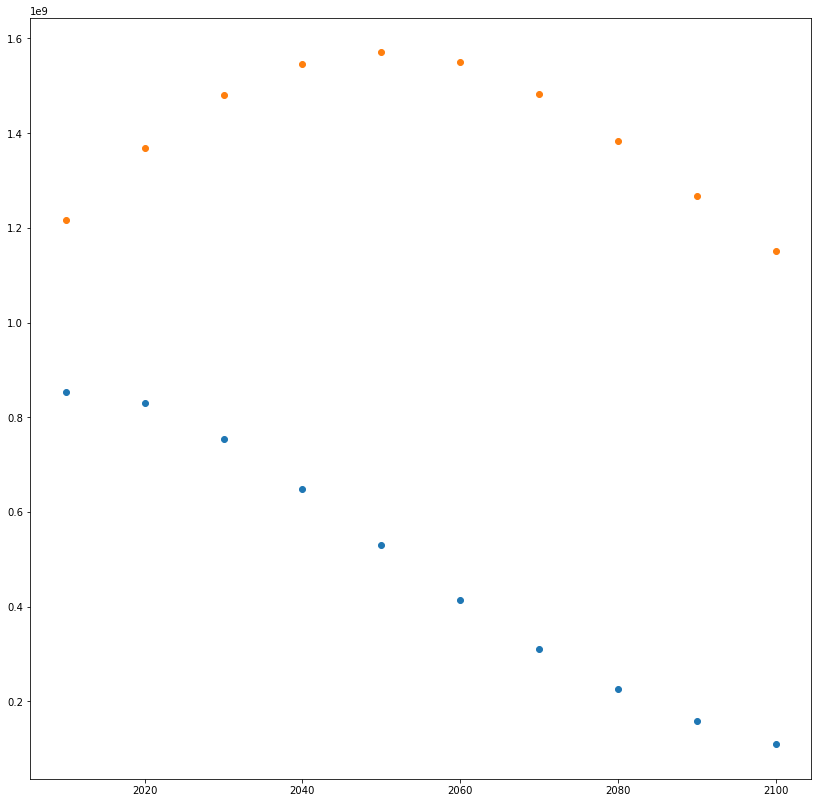

In [637]:
plt.figure(figsize=(14, 14))
plt.scatter(range(2010,2101,10),rural_pop_india)
plt.scatter(range(2010,2101,10),total_pop_india)
plt.show

### Task 2
Generate a global raster that shows only the cells that are projected to lose
population, and indicates how much the population in those cells is projected to
decline between 2010 and 2100.

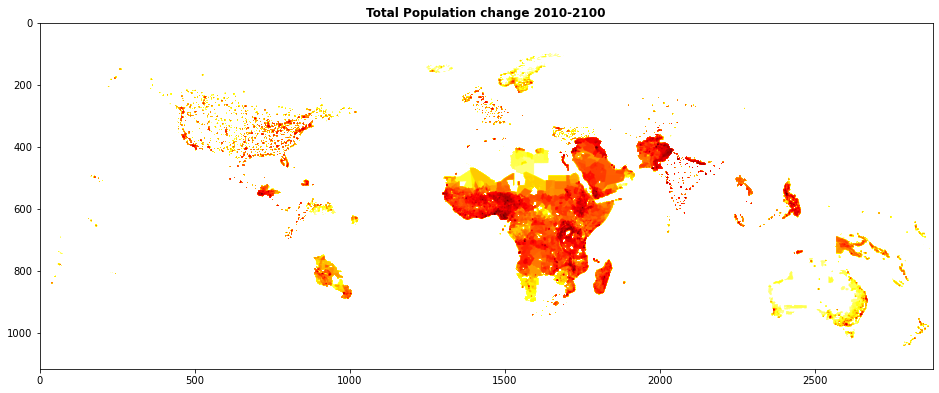

In [651]:
ax= plt.figure(figsize=(16, 16))
show((total_inequality_tif[9].read(1)- total_inequality_tif[0].read(1)),
     title='Total Population change 2010-2100', norm=LogNorm(), cmap='hot_r')

## 2. Spatial Autocorrelation


### Task 1
Download a shapefile of the world from naturalearthdata.com and perform a left join with the attached under5mortality.csv , which contains child mortality rates for each country in the world. The join should be done on the ISO_A3 column in the shapefile and the ISO column in the CSV, respectively.


In [180]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import os
import geopandas as gpd
import pandas as pd
from pysal.viz import mapclassify
import seaborn as sns
%matplotlib inline 

Download, unzip, set path & read the shapefile

In [181]:
zipurl = 'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('natural_earth_data')
shp_path= "natural_earth_data/ne_110m_admin_0_countries.shp"
countries = gpd.read_file(shp_path)

Drop some unused columns and rename column ISO_A3 to ISO to enable join with .csv

In [182]:
countries_ISO = countries[['ISO_A3', 'geometry']]
pd.set_option('display.max_rows', countries_ISO.shape[0]+1)

Read .csv file, drop unused columns, set inde to ISO enabling join with countries_ISO.shp and remove NAN values from column ChildMortality

In [183]:
under5mortality = pd.read_csv('under5mortality.csv')
under5mortality_ISO  = under5mortality [['ISO', 'ChildMortality']]

In [184]:
under5mortality_ISO.rename(columns = {'ISO':'ISO_A3'}, inplace = True) 
under5mortality_ISO['ChildMortality'] = under5mortality_ISO['ChildMortality'].fillna(0)

C:\Users\aarmo\Anaconda3\envs\geoanalysis\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\aarmo\Anaconda3\envs\geoanalysis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [185]:
under5mortality_ISO.head()

,ISO_A3,ChildMortality
0,AFG,67.9
1,ALB,8.8
2,DZA,24.0
3,AND,3.3
4,AGO,81.1


Join on column ISO and set index on the column for Task 2

In [370]:
joint= pd.merge(countries_ISO, under5mortality_ISO,
                how= 'left', on='ISO_A3')

In [371]:
joint= joint.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
pd.set_option('display.max_rows', joint.shape[0]+1)
print(joint)

    ISO_A3                                           geometry  ChildMortality
0      FJI  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...            25.3
1      TZA  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...            54.0
3      CAN  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...             5.1
4      USA  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...             6.6
5      KAZ  POLYGON ((87.35997 49.21498, 86.59878 48.54918...            10.0
6      UZB  POLYGON ((55.96819 41.30864, 55.92892 44.99586...            22.5
7      PNG  MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...            53.4
8      IDN  MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...            25.4
9      ARG  MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...            10.4
10     CHL  MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...             7.4
11     COD  POLYGON ((29.34000 -4.49998, 29.51999 -5.41998...            91.1
12     SOM  POLYGON ((41.58513 -1.68325, 40.99300 -0.85829...   

In [372]:
#joint= joint.set_index('ISO_A3')
joint

,ISO_A3,geometry,ChildMortality
0,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",25.3
1,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",54.0
3,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",5.1
4,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",6.6
5,KAZ,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",10.0
6,UZB,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",22.5
7,PNG,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...",53.4
8,IDN,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",25.4
9,ARG,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",10.4
10,CHL,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...",7.4


In [373]:
classi= mapclassify.Quantiles(joint['ChildMortality'], k=7)
classi

Quantiles               

    Interval       Count
------------------------
[  2.10,   4.23] |    24
(  4.23,   8.01] |    23
(  8.01,  14.67] |    23
( 14.67,  24.19] |    24
( 24.19,  44.71] |    23
( 44.71,  70.61] |    23
( 70.61, 127.20] |    24

In [374]:
classi =mapclassify.FisherJenks(joint['ChildMortality'], k=7)
classi

FisherJenks             

    Interval       Count
------------------------
[  2.10,  11.30] |    61
( 11.30,  24.00] |    33
( 24.00,  39.40] |    20
( 39.40,  55.40] |    18
( 55.40,  74.90] |    13
( 74.90, 100.20] |    14
(100.20, 127.20] |     5

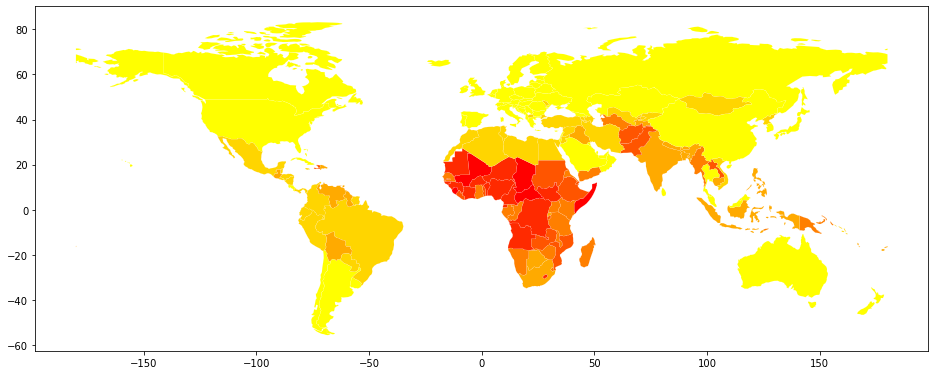

In [375]:
joint.plot(column='ChildMortality', scheme='fisher_jenks', k=7, 
         cmap=plt.cm.autumn_r, alpha=1, 
         edgecolor='w', linewidth=0.1, figsize=(16,16))

## Task 2 
Calculate the spatial weights matrix for the world based on border neighborhood and use the weights to calculate Moran's I for child mortality.

In [376]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import libpysal 
from libpysal import weights
from pysal.explore import esda
from pysal.viz import mapclassify

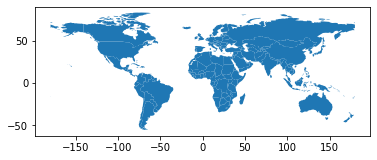

In [377]:
joint.plot()

Construct a contiguity weights matrix to define spatial connections through the existence of common boundaries. Queen was chosen
as it countries would only have to share a single point to be considered as neighbors. However, there does not seem to be a 
real difference in this case between rook and queen as countries do not just share a single point but a border.

In [416]:
qW = weights.KNN.from_dataframe(joint,k=10)# idVariable = 'ISO_A3')

C:\Users\aarmo\Anaconda3\envs\geoanalysis\lib\site-packages\libpysal\weights\weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Check if the data makes sense

In [417]:
qW.islands

[]

In [418]:
pd.DataFrame(qW.full()[0], 
             index=joint['ISO_A3'],
             columns=joint['ISO_A3'],
            ).astype(int)

ISO_A3,FJI,TZA,CAN,USA,KAZ,UZB,PNG,IDN,ARG,CHL,...,ETH,DJI,UGA,RWA,BIH,MKD,SRB,MNE,TTO,SSD
ISO_A3,,,,,,,,,,,,,,,,,,,,,
FJI,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
TZA,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
CAN,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
USA,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KAZ,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UZB,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PNG,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
IDN,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARG,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Set index 

In [419]:
#joint= joint.set_index('ISO_A3')

Plot all data

(<Figure size 1152x1152 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23090f9a588>)

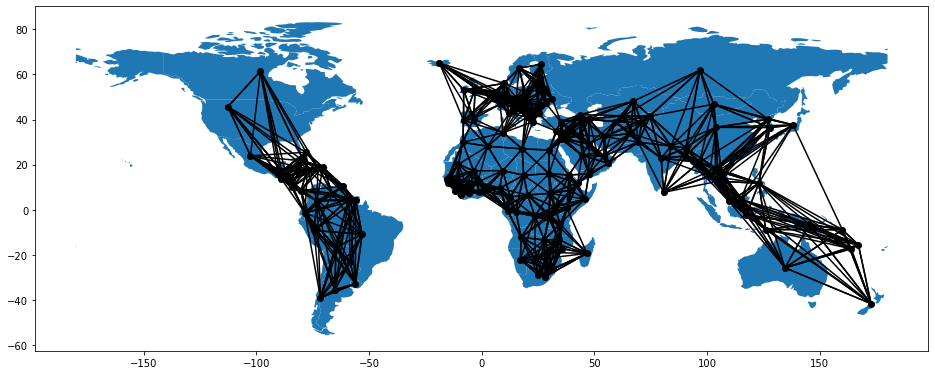

In [420]:
f, ax = plt.subplots(1, figsize=(16, 16))
joint.plot(ax=ax)
qW.plot(joint, ax=ax)

In [421]:
qW.transform = 'R'

Moran's Plot

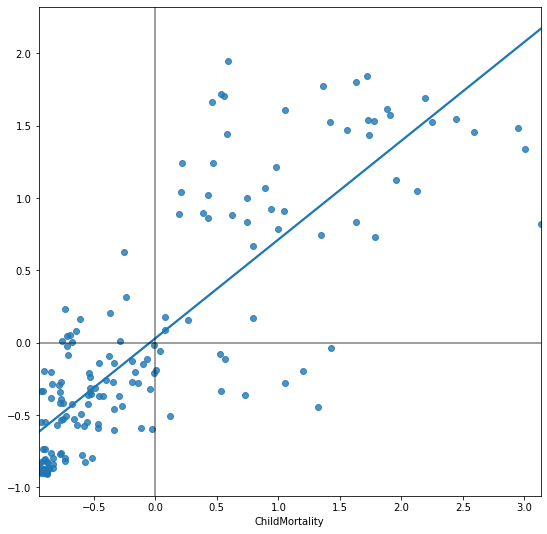

In [422]:
std_child_mortality= (joint['ChildMortality'] - joint['ChildMortality'].mean()) / joint['ChildMortality'].std()
std_w_score = pd.Series(weights.lag_spatial(qW, std_child_mortality), index=std_child_mortality.index)
f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(x=std_child_mortality, y=std_w_score, ci=None)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.show()

Calculate Moran's I for child mortality

In [423]:
mi = esda.Moran(joint['ChildMortality'],qW)
mi.I

0.6830353497589196

In [424]:
mi.p_sim

0.001